# Context Managers

## Introduction

In Python a context is the state surrounding a section of code.

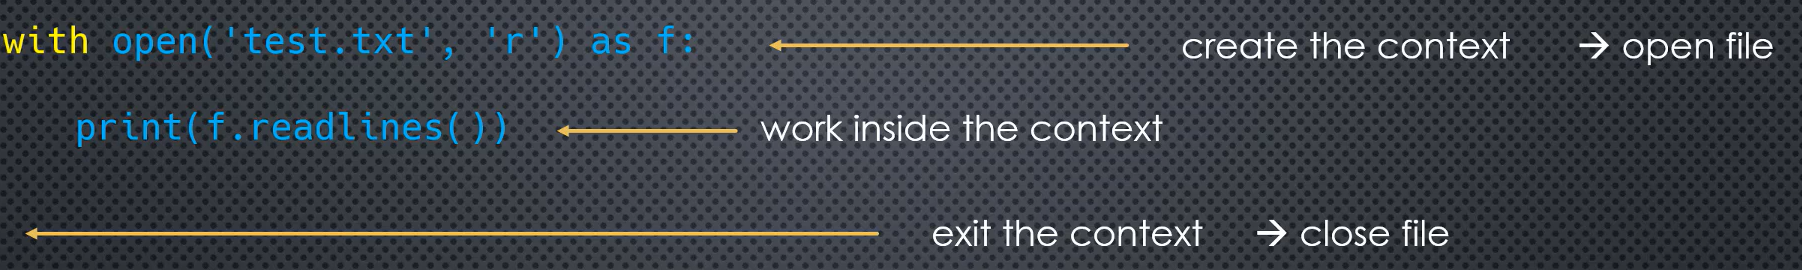

Context managers manage data in our scope on entry / or exit.<br>
Very useful for anything that needs to provide Enter/Exit, Start/Stop, Set/Reset.

## Context Managers

The finally section of a try always executes. It works even if inside a function and a return is in the try or except blocks. It's very useful for writing code that should execute no matter what happens. But this can get cumbersome!

In [1]:
def my_func(a: int):
    try:
        return 1 / a
    except ZeroDivisionError:
        return 0
    finally:
        print('finally called')

In [2]:
my_func(1)

finally called


1.0

In [3]:
my_func(0)

finally called


0

The pattern is:
- create some object,
- do some work with that object,
- clean up the object after we're done usin it.<b>

We want to make this easy:
- automatic cleanup after we are done using the object.

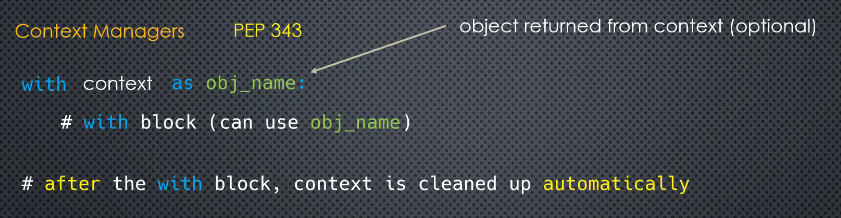

In [4]:
with open('file.txt') as f: # enter the context    (optional) an object is returned
    # file is now open
    pass

# file is now closed

Classes implement the <b>context managmenet protocol</b> by implementing two methods:
- \_\_enter\_\_ - setup, and optionally return some object
- \_\_exit\_\_ - tear down / cleanup

with CtxManager() as obj:<br>
___# do something<br>
done with context<br>
<br>
Behind the scenes it looks like this (over simplified/no exception handling):<br>
mgr = CtxManager()<br>
obj = mgr.\_\_enter\_\_()<br>
try:<br>
___# do something<br>
finally:<br>
___# done with context <br>
___mgr.\_\_exit\_\_()

Use Cases/Common Patterns:
- open - close,
- lock - release,
- change - reset,
- start - stop.

Examples:
- file context managers,
- Decimal contexts.

Suppose we had class MyClass() which implemented the context management protocol.

with MyClass() as obj:<b>
- creates an instance of MyClass -> no associated symbol, but an instance exists (let's call it my_instance)
- calls my_instance.\_\_enter\_\_()
- return value from \_\_enter\_\_ is assigned to obj (not the instance of MyClass that was created)

after the with block, or if an exception occurs inside the with block:
- my_instance.\_\_exit\_\_ is called

The with block is not like a function or a comprehension. The scope of anything in the with block (including the object from \_\_enter\_\_ is in the <b>same</b> scope as the with statement itself.

In [3]:
with open("file.txt") as f: # f is a symbol in global scope
    row = next(f) # row is also in the global scope

print(f) # f is closed, but the symbol exists
print(row) # row is available and has a value
print('row' in globals())
print('f' in globals())

<_io.TextIOWrapper name='file.txt' mode='r' encoding='cp1250'>
line1

True
True


The \_\_enter\_\_method should perform whatever setup it needs to and it can optionally return an object (captured by as statement).

The \_\_exit\_\_ method is more complicated. It runs even if an exception occurs in with block. But should it handle things differently if an exception occurred?
- maybe:
  - so it needs to know about any exceptions that occured,
  - it also needs to tell Python o silence the excepetion, or let it propagate

</b>Scenario 1<b>
- \_\_exit\_\_ receives error, performs some clean up and silences error,
- print statement runs,
- no exception is seen.

</b>Scenario 2<b>
- \_\_exit\_\_ receives error, performs some clean up and let's error propagate,
- print statement does not run,
- the ValueException is seen.

The \_\_exit\_\_ method needs three arguments:
- the exception type that occured (if any, None otherwise),
- the exception value that occured (if any, None otherwise),
- the traceback object if an exception occurred (if any, None otherwise).

It returns True or False:
- True = silence any raised exception,
- False = do not silence a raised exception.

In [8]:
with open('file.txt', 'w') as file:
    print('inside with: file closed?', file.closed)

print('after with: file closed?', file.closed)

inside with: file closed? False
after with: file closed? True


In [9]:
def test():
    with open('file.txt', 'w') as file:
        print('inside with: file closed?', file.closed)
        return file # returning in the middle of the with block
        print('here - will never run')

In [10]:
file = test()

inside with: file closed? False


In [11]:
file.closed # even though we returned something in the middle of the with block

True

In [14]:
with open('file.txt', 'w') as file:
    print('inside with: file closed?', file.closed)
    raise ValueError()
    print('no')

inside with: file closed? False


ValueError: 

In [15]:
file.closed # closed even though there was an Exception

True

In [30]:
class MyContext:
    def __init__(self):
        print('init running...')
        self.obj = None

    def __enter__(self):
        print('entering context...')
        self.obj = 'the Return object'
        return self.obj

    def __exit__(self, exc_type, exc_value, exc_tb: "traceback"):
        print('exiting context...')
        if exc_type:
            print(f'*** Error occured: {exc_type}, {exc_value}')
        return False # propagating the error if it occurs
        

In [31]:
with MyContext() as obj:
    print('inside with block:', obj)
    raise ValueError('custom message')

init running...
entering context...
inside with block: the Return object
exiting context...
*** Error occured: <class 'ValueError'>, custom message


ValueError: custom message

In [32]:
class MyContext:
    def __init__(self):
        print('init running...')
        self.obj = None

    def __enter__(self):
        print('entering context...')
        self.obj = 'the Return object'
        return self.obj

    def __exit__(self, exc_type, exc_value, exc_tb: "traceback"):
        print('exiting context...')
        if exc_type:
            print(f'*** Error occured: {exc_type}, {exc_value}')
        return True # silencing the error if it occurs
        

In [33]:
with MyContext() as obj:
    print('inside with block:', obj)
    raise ValueError('custom message')

init running...
entering context...
inside with block: the Return object
exiting context...
*** Error occured: <class 'ValueError'>, custom message


In [34]:
# the with block does not have its own local scope
obj

'the Return object'

In [37]:
class Resource:
    def __init__(self, name):
        self.name = name
        self.state = None

In [38]:
class ResourceManager:
    def __init__(self, name):
        self.name = name
        self.resource = None

    def __enter__(self):
        print('entering context')
        self.resource = Resource(self.name)
        self.resource.state = 'created'
        return self.resource

    def __exit__(self, exc_type, exc_value, exc_tb):
        print('exiting context')
        self.resource.state = 'destroyed'
        if exc_type:
            print('error occurred')
        return False

In [41]:
with ResourceManager('spam') as res:
    print(f'{res.name} = {res.state}')
print(f'{res.name} = {res.state}') # res exists in our global scope

entering context
spam = created
exiting context
spam = destroyed


In [42]:
res_manager = ResourceManager('spam') # we can create a context manager in separate line
print('-----------')
with res_manager as res: 
        print(f'{res.name} = {res.state}')
print(f'{res.name} = {res.state}')
'res' in globals() # res exists in our global scope

-----------
entering context
spam = created
exiting context
spam = destroyed


True

In [9]:
class File: # custom context manager for opening/closing files
    def __init__(self, name, mode):
        self.name = name
        self.mode = mode

    def __enter__(self):
        print('opening file...')
        self.file = open(self.name, self.mode)
        return self.file

    def __exit__(self, exc_type, exc_value, exc_tb):
        print('closing file...')
        self.file.close()
        return False
        

In [10]:
with File('file.txt.', 'r') as f:
    print(f.readlines())

opening file...
['line1\n', 'line2']
closing file...


In [11]:
def test():
    with File('file.txt.', 'r') as f:
        print(f.readlines())
        return f

In [12]:
f = test() # closing file still runs, same if we raised an Error in the with block

opening file...
['line1\n', 'line2']
closing file...


## Caveat when used with Lazy Iterators

In [13]:
import csv

def read_data():
    with open('file.txt') as f:
        return csv.reader(f)

In [15]:
reader = read_data()
type(reader)

_csv.reader

In [16]:
for row in reader: # iteration here (reader is a lazy iterator)
    print(row) # when we returned the reader, we left the with block and the file was closed

ValueError: I/O operation on closed file.

In [19]:
def read_data():
    with open('file.txt') as f:
        yield from csv.reader(f) # we can also return a list, but it's eager

In [20]:
reader = read_data()
type(reader)

generator

In [21]:
for row in reader: # iteration here (reader is a lazy iterator)
    print(row) 

['line1']
['line2']


## Not just a Context Manager
Just because our class implements the context management protocol, it does not mean that it cannot implement other things as well.

In [22]:
with open('file.txt', 'r') as f:
    print(f.readlines())

['line1\n', 'line2']


In [24]:
f = open('file.txt')
print(f.readlines())
f.close() # another functionality of open

['line1\n', 'line2']


In [25]:
open('file.txt').close()

In [26]:
class DataIterator:
    def __init__(self, fname):
        self._fname = fname
        self._f = None

    def __iter__(self):
        return self

    def __next__(self):
        row = next(self._f)
        return row.strip('\n').split(',')

    def __enter__(self):
        self._f = open(self._fname)
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        if not self._f.closed:
            self._f.close()
        return False

In [28]:
with DataIterator('file.txt') as data:
    for row in data:
        print(row)

['line1']
['line2']


In [30]:
data = DataIterator('file.txt') # we have a data iterator, but the file has not been opened
for row in data:
    print(row)

TypeError: 'NoneType' object is not an iterator

In [31]:
with data as rows:
    for row in rows:
        print(row)

['line1']
['line2']


## Additional Uses

Pattern: <b>Open - Close</b>

Pattern: <b>Start - Stop</b>

In [48]:
from time import perf_counter, sleep

In [49]:
class Timer:
    def __init__(self):
        self.elapsed = 0

    def __enter__(self):
        self.start = perf_counter()
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.stop = perf_counter()
        self.elapsed = self.stop - self.start
        return False

In [51]:
with Timer() as t:
    print('zzz....')
    sleep(3)
    print('I woke up')

t.elapsed

zzz....
I woke up


3.0004412999987835

Pattern: <b>Lock - Release</b>

Pattern: <b>Change - Reset</b>

In [35]:
import decimal

decimal.getcontext()

Context(prec=28, rounding=ROUND_HALF_EVEN, Emin=-999999, Emax=999999, capitals=1, clamp=0, flags=[], traps=[InvalidOperation, DivisionByZero, Overflow])

In [36]:
# a lot of work
old_prec = decimal.getcontext().prec
decimal.getcontext().prec = 4
print(decimal.Decimal(1) / decimal.Decimal(3))
decimal.getcontext().prec = old_prec
print(decimal.Decimal(1) / decimal.Decimal(3))

0.3333
0.3333333333333333333333333333


In [41]:
class precision:
    def __init__(self, prec):
        self._prec = prec
        self._old_prec = decimal.getcontext().prec
        
    def __enter__(self):
        decimal.getcontext().prec = self._prec

    def __exit__(self, exc_type, exc_value, exc_tb):
        decimal.getcontext().prec = self._old_prec
        return False

In [42]:
with precision(4):
    print(decimal.Decimal(1) / decimal.Decimal(3))
print(decimal.Decimal(1) / decimal.Decimal(3))

0.3333
0.3333333333333333333333333333


In [43]:
with decimal.localcontext() as ctx:
    ctx.prec = 3
    print(decimal.Decimal(1) / decimal.Decimal(3))
print(decimal.Decimal(1) / decimal.Decimal(3))

0.333
0.3333333333333333333333333333


In [52]:
import sys

class OutToFile:
    def __init__(self, fname):
        self._fname = fname
        self._current_stdout = sys.stdout

    def __enter__(self):
        self._file = open(self._fname, 'w')
        sys.stdout = self._file

    def __exit__(self, exc_type, exc_value, exc_tb):
        sys.stdout = self._current_stdout
        self._file.close()
        return False

In [53]:
with OutToFile("text.txt"):
    print('Line 1')
    print('Line 2')

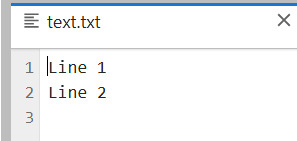

In [55]:
print('Line 1') # we are no longer redirecting print to a file

Line 1


In [59]:
class ListMaker:
    def __init__(self, title, prefix='-', indent=3):
        self._title = title
        self._prefix = prefix
        self._indent = indent
        self._current_indent = 0
        print(title)

    def __enter__(self):
        self._current_indent += self._indent
        return self

    def __exit__(self, exec_type, exec_val, exec_tb):
        self._current_indent -= self._indent
        return False

    def print_item(self, arg):
        s = ' ' * self._current_indent + self._prefix + ' ' + str(arg)
        print(s)
        

In [66]:
with OutToFile('items.txt'): # nesting context managers - redirecting stdout to a file
    with ListMaker('Items') as lm:
        lm.print_item('Item 1')
        with lm:
            lm.print_item('sub item 1a')
            lm.print_item('sub item 1b')
            with lm:
                lm.print_item('********')
        lm.print_item('Item 2')        

In [67]:
with open('items.txt') as f:
    for row in f:
        print(row, end='')

Items
   - Item 1
      - sub item 1a
      - sub item 1b
         - ********
   - Item 2


## Generators and Context Managers

We can mimic the pattern used in context managers using a generator.

In [68]:
def open_file(fname, mode):
    f = open(fname, mode)
    try:
        yield f
    finally:
        f.close()

In [69]:
ctx = open_file('file.txt', 'r') # a generator
f = next(ctx) # opens file, and yields it
next(ctx) # closes file -> StopIteration exception

StopIteration: 

In [70]:
ctx = open_file('file.txt', 'r') # a generator
f = next(ctx) # opens file, and yields it

try:
    pass
    # do work with file
finally:
    try:
        next(ctx)
    except StopIteration:
        pass

This works in general.

Creating a Context Manager from a Generator function

In [14]:
def my_gen():
    try:
        print('creating context and yielding object')
        yield [1, 2, 3, 4]
    finally:
        print('exiting context and cleaning up')

In [15]:
gen = my_gen()

In [16]:
lst = next(gen)

creating context and yielding object


In [17]:
lst

[1, 2, 3, 4]

In [18]:
try:
    next(gen)
except StopIteration:
    pass

exiting context and cleaning up


In [19]:
class GenCtxManager:
    def __init__(self, gen_func, *args, **kwargs):
        self.gen = gen_func(*args, **kwargs)
        
    def __enter__(self):
        obj = next(self.gen)
        return obj

    def __exit__(self, exc_type, exc_value, exc_tb):
        try:
            next(gen)
        except StopIteration:
            pass
        return False

In [20]:
with GenCtxManager(my_gen) as l:
    print(l)

creating context and yielding object
[1, 2, 3, 4]
exiting context and cleaning up


In [21]:
def open_file(fname, mode):
    f = open(fname, mode)
    try:
        yield f
    finally:
        f.close()

In [22]:
with GenCtxManager(open_file, 'file.txt', 'r') as data:
    for row in data:
        print(row, end='')

line1
line2

## The @contextmanager Decorator

We saw how to create a context manager using a class and a generator function, however in our approach we have to create the generator object first, and use the GenCtxManager class and we lose clarity of what the context manager is.

In [23]:
def contextmanager_dec(gen_fn):
    def helper(*args, **kwargs):
        gen = gen_fn(*args, **kwargs)
        return GenCtXManager(gen)
    return helper

In [24]:
@contextmanager_dec
def open_file(f_name):
    f = open(f_name)
    try:
        yield f
    finally:
        f.close()

In [25]:
# equivalent to
open_file = contextmanager_dec(open_file)

open_file is now actually the helper closure, so calling open_file(f_name) calls helper(f_name) which creates the generator object with returns GenContextManager instance.<br>
We are now working with a context manager (with open_file(f_name)).

One of the goals when context managers were introduced to Python was to ensure generator functions could be used to easily create them.

The contextlib module provide us we our existing functionality, but even more complex.

contextlib.contextmanager -> decorator which turns a generator function into a context manager.

In [27]:
from contextlib import contextmanager # contextmanager is a decorator

In [32]:
@contextmanager
def open_file(f_name, mode='r'):
    print('opening file...')
    f = open(f_name, mode)
    try:
        yield f
    finally:
        print('closing file...')
        f.close()

In [33]:
with open_file('file.txt', 'r') as f:
    print(f.readlines())

opening file...
['line1\n', 'line2']
closing file...


In [34]:
from time import perf_counter, sleep

In [35]:
@contextmanager
def timer():
    stats = dict()
    stats['start'] = perf_counter()
    try:
        yield stats
    finally:
        stats['end'] = perf_counter()
        stats['elapsed'] = stats['end'] - stats['start']

In [36]:
with timer() as stats:
    sleep(2)

In [37]:
print(stats)

{'start': 97988.4402839, 'end': 97990.4405619, 'elapsed': 2.0002780000068014}


In [38]:
import sys

In [39]:
@contextmanager
def out_to_file(fname):
    current_stdout = sys.stdout
    file = open(fname, 'w')
    sys.stdout = file
    try:
        yield None
    finally:
        sys.stdout = current_stdout
        file.close()

In [40]:
with out_to_file('test.txt'):
    print('line 1')
    print('line 2 ***')

In [41]:
print('hello')

hello


In [42]:
with open('test.txt', 'r') as f:
    print(f.readlines())

['line 1\n', 'line 2 ***\n']


In [44]:
from contextlib import redirect_stdout # built-in redirecting stdout

In [45]:
with open('test.txt', 'w') as f:
    with redirect_stdout(f): # redirect_stdout requires a file object
        print('hello')

In [46]:
with open('test.txt', 'r') as f:
    print(f.readlines())

['hello\n']


## Nested Context Managers

The **with** statement in Python can open more than one context managers.

In [47]:
with open('data/file1.txt') as f1, open('data/file2.txt') as f2:
    print(f1.readlines())
    print(f2.readlines())

['file1_line1\n', 'file1_line2\n', 'file1_line3']
['file2_line1\n', 'file2_line2\n', 'file2_line3']


We can also nest the context managers.

In [49]:
with open('data/file1.txt') as f1:
    with open('data/file2.txt') as f2:
        with open('data/file3.txt') as f3:
            print(f1.readlines())
            print(f2.readlines())
            print(f3.readlines())

['file1_line1\n', 'file1_line2\n', 'file1_line3']
['file2_line1\n', 'file2_line2\n', 'file2_line3']
['file3_line1\n', 'file3_line2\n', 'file3_line3']


The problem in both cases is that we have to now the number of files before opening them.

In [50]:
from contextlib import contextmanager

In [52]:
@contextmanager
def open_file(f_name):
    print(f'opening {f_name}')
    f = open(f_name)
    try:
        yield f
    finally:
        print(f'closing {f_name}')
        f.close()

In [61]:
f_names = 'data/file1.txt', 'data/file2.txt', 'data/file3.txt'

# creating context managers
exits, enters = [], []

for f_name in f_names:
    ctx = open_file(f_name)
    enters.append(ctx.__enter__)
    exits.append(ctx.__exit__)

closing data/file2.txt
closing data/file1.txt
closing data/file3.txt


In [62]:
# entering the context mangers
files = [enter() for enter in enters]

opening data/file1.txt
opening data/file2.txt
opening data/file3.txt


In [63]:
# doing some work
while True:
    try:
        rows = [next(f).strip('\n') for f in files]
    except StopIteration:
        break
    else:
        row = ','.join(rows)
        print(row)

file1_line1,file2_line1,file3_line1
file1_line2,file2_line2,file3_line2
file1_line3,file2_line3,file3_line3


In [66]:
# exiting context managers
for exit in exits[::-1]:
    exit(None, None, None) # __exit__ method requires 3 positional arguments

closing data/file3.txt
closing data/file2.txt
closing data/file1.txt


In [67]:
class NestedContexts:
    def __init__(self, *contexts):
        self._enters = []
        self._exits = []
        self._values = []

        for ctx in contexts:
            self._enters.append(ctx.__enter__)
            self._exits.append(ctx.__exit__)

    def __enter__(self):
        for enter in self._enters:
            self._values.append(enter())
        return self._values

    def __exit__(self, exc_type, exc_value, exc_tb):
        for exit in self._exits[::-1]:
            exit(exc_type, exc_value, exc_tb)
        return False

In [68]:
with NestedContexts(open_file('data/file1.txt'),
                    open_file('data/file2.txt'),
                    open_file('data/file3.txt')) as files:
    print('do work here')

opening data/file1.txt
opening data/file2.txt
opening data/file3.txt
do work here
closing data/file3.txt
closing data/file2.txt
closing data/file1.txt


In [69]:
contexts = [open_file(f_name) for f_name in f_names]
with NestedContexts(*contexts) as files:
    print('do work here')
    

opening data/file1.txt
opening data/file2.txt
opening data/file3.txt
do work here
closing data/file3.txt
closing data/file2.txt
closing data/file1.txt


In [70]:
class NestedContexts:
    def __init__(self):
        self._exits = []

    def __enter__(self):
        return self

    def enter_context(self, ctx):
        self._exits.append(ctx.__exit__)
        value = ctx.__enter__()
        return value

    def __exit__(self, exc_type, exc_value, exc_tb):
        for exit in self._exits[::-1]:
            exit(exc_type, exc_value, exc_tb)
        return False

In [71]:
f_names = 'data/file1.txt', 'data/file2.txt', 'data/file3.txt'

In [72]:
with NestedContexts() as stack: # now we don't have any context managers in our "stack" of contexts
    files = [stack.enter_context(open_file(f)) for f in f_names]

    # do work
    print('do work')

opening data/file1.txt
opening data/file2.txt
opening data/file3.txt
do work
closing data/file3.txt
closing data/file2.txt
closing data/file1.txt


In [73]:
from contextlib import ExitStack # more robust NestedContexts

In [77]:
f_names = 'data/file1.txt', 'data/file2.txt', 'data/file3.txt'

with ExitStack() as stack:
    files = [stack.enter_context(open_file(f)) for f in f_names]

    while True:
        try:
            rows = [next(f).strip('\n') for f in files]
        except StopIteration:
            break
        else:
            row = ','.join(rows)
            print(row)

opening data/file1.txt
opening data/file2.txt
opening data/file3.txt
file1_line1,file2_line1,file3_line1
file1_line2,file2_line2,file3_line2
file1_line3,file2_line3,file3_line3
closing data/file3.txt
closing data/file2.txt
closing data/file1.txt


## Project
You are provided two CSV files: cars.csv, personal_info.csv. The basic goal will be to create a context manager that only requires the file name and provides us an iterator we can use to iterate over the data in those files. The iterator should yield named tuples with field names based on the header row in the CSV file. Assume, all fields are just strings.

### Goal 1 

For this goal implement the context manager using a context manager class, i.e. a class that implements the context manager protocol (\_\_enter\_\_, \_\_ext\_\_). Make sure your iterator uses lazy evaluation. Try to create a single class that implements both the context manager protocl and the iterator protocol.

In [60]:
from collections import namedtuple
import csv

class CtxMng:
    def __init__(self, fname):
        self._fname = fname

    def __iter__(self):
        return self

    def __enter__(self):
        self._file = open(self._fname, 'r')
        self._reader = csv.reader(self._file, self.get_dialect()) # get_dialect() provides us with e.g. the delimiter
        headers = map(lambda s: s.lower(), next(self._reader)) # getting the lowercase headers
        self._nt = namedtuple("Data", field_names=headers) # the named tuple
        return self # iter(self) => self

    def __next__(self):
        if self._file.closed: # in case somebody wanted to use the iterator beyond the with block (out of context)
            raise StopIteration
        else:
            return self._nt(*next(self._reader)) # getting the next named tuple

    def get_dialect(self):
        with open(self._fname) as f:
            return csv.Sniffer().sniff(next(f)) # csv.Sniffer().sniff() returns a dialect object with information about our file
               
    def __exit__(self, exc_type, exc_value, exc_tb):
        self._file.close()
        return False

In [56]:
from itertools import islice

with CtxMng('data/personal_info.csv') as it:
    for row in islice(it, 5):
        print(row)

with CtxMng('data/cars.csv') as it:
    for row in islice(it, 5):
        print(row)        

Data(ssn='100-53-9824', first_name='Sebastiano', last_name='Tester', gender='Male', language='Icelandic')
Data(ssn='101-71-4702', first_name='Cayla', last_name='MacDonagh', gender='Female', language='Lao')
Data(ssn='101-84-0356', first_name='Nomi', last_name='Lipprose', gender='Female', language='Yiddish')
Data(ssn='104-22-0928', first_name='Justinian', last_name='Kunzelmann', gender='Male', language='Dhivehi')
Data(ssn='104-84-7144', first_name='Claudianus', last_name='Brixey', gender='Male', language='Afrikaans')
Data(car='Chevrolet Chevelle Malibu', mpg='18.0', cylinders='8', displacement='307.0', horsepower='130.0', weight='3504.', acceleration='12.0', model='70', origin='US')
Data(car='Buick Skylark 320', mpg='15.0', cylinders='8', displacement='350.0', horsepower='165.0', weight='3693.', acceleration='11.5', model='70', origin='US')
Data(car='Plymouth Satellite', mpg='18.0', cylinders='8', displacement='318.0', horsepower='150.0', weight='3436.', acceleration='11.0', model='70', 

### Goal 2
Re-implement what you did in Goal 1, but using a generator function instead.

In [57]:
import contextlib

@contextlib.contextmanager
def gen_func(fname):
    def get_dialect():
        with open(fname) as f:
            return csv.Sniffer().sniff(next(f))
    
    file = open(fname, 'r')
    try:
        reader = csv.reader(file, get_dialect())
        headers = map(lambda s: s.lower(), next(reader))
        Data = namedtuple('Data', headers)
        yield (Data(*row) for row in reader) # we want to return an iterator which iterates through the rows of data (reader)
    finally:
        file.close()

In [58]:
from itertools import islice

with gen_func("data/cars.csv") as it:
    for row in islice(it, 5):
        print(row)

Data(car='Chevrolet Chevelle Malibu', mpg='18.0', cylinders='8', displacement='307.0', horsepower='130.0', weight='3504.', acceleration='12.0', model='70', origin='US')
Data(car='Buick Skylark 320', mpg='15.0', cylinders='8', displacement='350.0', horsepower='165.0', weight='3693.', acceleration='11.5', model='70', origin='US')
Data(car='Plymouth Satellite', mpg='18.0', cylinders='8', displacement='318.0', horsepower='150.0', weight='3436.', acceleration='11.0', model='70', origin='US')
Data(car='AMC Rebel SST', mpg='16.0', cylinders='8', displacement='304.0', horsepower='150.0', weight='3433.', acceleration='12.0', model='70', origin='US')
Data(car='Ford Torino', mpg='17.0', cylinders='8', displacement='302.0', horsepower='140.0', weight='3449.', acceleration='10.5', model='70', origin='US')


In [59]:
with gen_func("data/personal_info.csv") as it:
    for row in islice(it, 5):
        print(row)

Data(ssn='100-53-9824', first_name='Sebastiano', last_name='Tester', gender='Male', language='Icelandic')
Data(ssn='101-71-4702', first_name='Cayla', last_name='MacDonagh', gender='Female', language='Lao')
Data(ssn='101-84-0356', first_name='Nomi', last_name='Lipprose', gender='Female', language='Yiddish')
Data(ssn='104-22-0928', first_name='Justinian', last_name='Kunzelmann', gender='Male', language='Dhivehi')
Data(ssn='104-84-7144', first_name='Claudianus', last_name='Brixey', gender='Male', language='Afrikaans')
